# Getting Started

## Split approach based on filetype

- CSVs: viewed as is, read in and described
- Docx: parsed and returned as strings
- PDFs: if a PDF is searchable, we can extract the text directly, otherwise we must use OCR
- Txts: viewed as is, parsed, etc.

### CSV viewing

In [13]:
import numpy as np
import pandas as pd
import os
import xml.etree.ElementTree as ET
import zipfile

addl_dir = "../input/cityofla/CityofLA/Additional data"

# First up: An example of what LA would like our output to look like at the end of the day
sample_template = pd.read_csv(os.path.join(addl_dir, 'sample job class export template.csv'))
display(sample_template)

,FILE_NAME,JOB_CLASS_TITLE,JOB_CLASS_NO,REQUIREMENT_SET_ID,REQUIREMENT_SUBSET_ID,JOB_DUTIES,EDUCATION_YEARS,SCHOOL_TYPE,EDUCATION_MAJOR,EXPERIENCE_LENGTH,FULL_TIME_PART_TIME,EXP_JOB_CLASS_TITLE,EXP_JOB_CLASS_ALT_RESP,EXP_JOB_CLASS_FUNCTION,COURSE_COUNT,COURSE_LENGTH,COURSE_SUBJECT,MISC_COURSE_DETAILS,DRIVERS_LICENSE_REQ,DRIV_LIC_TYPE,ADDTL_LIC,EXAM_TYPE,ENTRY_SALARY_GEN,ENTRY_SALARY_DWP,OPEN_DATE
0,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,1,A,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,COMPUTER SCIENCE|INFORMATION SYSTEMS|GEOGRAPHI...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
1,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,A,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,FULL-TIME,MANAGEMENT ASSISTANT,NaN,"the development, analysis, implementation or m...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
2,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,B,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,FULL-TIME,MANAGEMENT ASSISTANT,NaN,"performing cost benefit, feasibility and requi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
3,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,2,C,"A Systems Analyst analyzes procedures, methods...",4.0,COLLEGE OR UNIVERSITY,NaN,2.0,FULL-TIME,MANAGEMENT ASSISTANT,NaN,performing system implementation and support a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17
4,SYSTEMS ANALYST 1596 102717.txt,Systems Analyst,1596,3,A,"A Systems Analyst analyzes procedures, methods...",NaN,NaN,NaN,2.0,FULL-TIME,SYSTEMS AIDE,NaN,NaN,4.0,"3M, 4Q",INFORMATION SYSTEMS|SYSTEMS ANALYSIS|closely r...,At least three of the courses must be from the...,M,NaN,NaN,OPEN_INT_PROM,68611-100307,70908-88092,10/27/17


In [15]:
# The data dictionary for reference:
data_dictionary = pd.read_csv(os.path.join(addl_dir, 'kaggle_data_dictionary.csv'))
display(data_dictionary)

,Field Name,Annotation Letter,Description,Data Type,Allowable Values,Accepts Null Values?,Additional Notes
0,FILE_NAME,NaN,The file name of the job bulletin from which e...,String,NaN,No,NaN
1,JOB_CLASS_TITLE,A,"The title of the particular class (e.g., Syste...",String,Any job title matching in in supplied job bull...,No,NaN
2,JOB_CLASS_NO,B,The 4-digit code that corresponds to the job c...,String,Any four character numeric string matching one...,No,Some classes have three non-zero digits — e.g....
3,REQUIREMENT_SET_ID,D1,A main requirement that has to be filled. Thes...,Integer,Any positive integer,No,NaN
4,REQUIREMENT_SUBSET_ID,D2,"A secondary requirement that has to be filled,...",String,Any letter or combination of letters.,No,"A-Z represents 1-26. In the case of 27th, 28th..."
5,JOB_DUTIES,C,A summary of what someone does in the particul...,String,NaN,No,NaN
6,EDUCATION_YEARS,F,Years required in a particular education program,Float,Any positive float representing years or a fra...,Yes,Any job description that mentions months shoul...
7,SCHOOL_TYPE,G,School Type: School type required (e.g. colleg...,String,"COLLEGE OR UNIVERSITY, HIGH SCHOOL, APPRENTICE...",Yes,Allowable value list is most likely incomplete...
8,EDUCATION_MAJOR,H,Major or concentration required,String,NaN,Yes,A list of many sufficient majors should appear...
9,EXPERIENCE_LENGTH,I,Years required in a particular job class or ex...,Float,NaN,Yes,Some classes may specify months rather than ye...


In [24]:
# Job titles listing:
job_titles = pd.read_csv(os.path.join(addl_dir, 'job_titles.csv'), names=['JOB TITLES'])
display(job_titles.head())

,JOB TITLES
0,311 DIRECTOR
1,ACCOUNTANT
2,ACCOUNTING CLERK
3,ACCOUNTING RECORDS SUPERVISOR
4,ADMINISTRATIVE ANALYST


### Docx conversion

In [ ]:
class Docx(object):
    '''Helper to pull Docx text into a python notebook.
    
    Args:
        - path (str): where the docx file is stored.
    Methods:
        - read: open the doc, return its text.
    '''
    
    def __init__(self, path):
        self.path = path

    def read(self):
        '''Open the doc, return its text.'''
        zipf = zipfile.ZipFile(self.path)
        filelist = zipf.namelist()
        text = Docx.xml2text(zipf.read('word/document.xml'))
        zipf.close()
        return text

    @staticmethod
    def qn(tag):
        '''Source: docx2txt'''
        nsmap = {'w': 'http://schemas.openxmlformats.org/wordprocessingml/2006/main'}
        prefix, tagroot = tag.split(':')
        uri = nsmap[prefix]
        return '{{{}}}{}'.format(uri, tagroot)

    @staticmethod
    def xml2text(xml, mapping=None, version='new'):
        '''Source: docx2txt'''
        if mapping is None:
            if version == 'default':
                mapping = {'tab': '\t',
                           'break': '\n',
                           'page': '\n\n'}
            elif version == 'new':
                mapping = {'tab':' ', 'break':' ', 'page':' '}
        text = u''
        root = ET.fromstring(xml)
        for child in root.iter():
            if child.tag == Docx.qn('w:t'):
                t_text = child.text
                text += t_text if t_text is not None else ''
            elif child.tag == Docx.qn('w:tab'):
                text += mapping['tab']
            elif child.tag in (Docx.qn('w:br'), Docx.qn('w:cr')):
                text += mapping['break']
            elif child.tag == Docx.qn("w:p"):
                text += mapping['page']
        return text

In [10]:
print('`Description of promotions in job bulletins`.docx contents:\n')
print(Docx(os.path.join(addl_dir, 'Description of promotions in job bulletins.docx')).read())

`Description of promotions in job bulletins`.docx contents:

 City of LA - Data Science for Good - Kaggle Competition  URL: https://www.kaggle.com/c/data-science-for-good-city-of-los-angeles  Description of promotions in job bulletins With your structured version of the job bulletins, you should be able to directly connect a job class to any other job classes that are explicitly mentioned as a prerequisite for application (an explicit promotional pathway), as they will be clearly identified in each row of the output. For instance, the text of the description for Senior Systems Analyst states the requirement of “Two years of full-time paid experience in a class at the level of Systems Analyst.” In this case, the lower job class of Systems Analyst is explicitly mentioned in the description for Senior Systems Analyst. The ability to promote between these job classes is thus stated explicitly. Note that you will not be evaluated on the extraction of implicit promotional pathways, which are

### PDF Conversion

In [ ]:
!apt-get install -y poppler-utils
# Note: Internet must be enabled on this kernel (under settings on right-hand side)

In [8]:
import tempfile
import shlex
from subprocess import Popen, PIPE, STDOUT

class Pdf(object):
    '''Parse *Searchable* PDF objects.
    Args:
        - path (str): where the docx file is stored.
    Methods:
        - read: open the doc, return its text.
    '''
    def __init__(self, path):
        self.path = path

    def read(self):
        local_filename = tempfile.NamedTemporaryFile(delete=False).name
        run_command_line(f'pdftotext {self.path} {local_filename} -layout')
        with open(local_filename, 'r') as f:
            return '\n'.join(f.readlines())

def run_command_line(command_line_args):
    '''Utility for running command line program via python
    Args:
        - command_line_args (str): what should be passed to command line
    Returns:
        - Bool: (not process.wait()) == 1 if program exited without error
    '''
    process = Popen(shlex.split(command_line_args), stdout=PIPE, stderr=STDOUT)
    with process.stdout:
        return parse_subprocess(process.stdout)
    return not process.wait()

def parse_subprocess(pipe):
    '''Parse output from subprocess.'''
    return [line for line in iter(pipe.readline, b'')]

In [9]:
# It doesn't seem like any of these PDFs are searchable, would need to turn to OCR for parsing.
Pdf(os.path.join(addl_dir, 'PDFs/2014/September 2014/09262014/CHIEF INSPECTOR 4254.pdf')).read()

''

### Text viewing

In [25]:
# Code from the starter kernel to iterate over Job Bulletins directory
bulletin_dir = "../input/cityofla/CityofLA/Job Bulletins"
data_list = []
for filename in os.listdir(bulletin_dir):
    with open(bulletin_dir + "/" + filename, 'r', errors='ignore') as f:
        raw = []
        for line in f.readlines():
            raw.append(line)
            if "Open Date:" in line:
                job_bulletin_date = line.split("Open Date:")[1].split("(")[0].strip()
        data_list.append([filename, job_bulletin_date, raw])

# Form a DF 
df = pd.DataFrame(data_list, columns=["FILE_NAME", "OPEN_DATE", "RAW"])
df.OPEN_DATE = pd.to_datetime(df.OPEN_DATE)
df.head()

,FILE_NAME,OPEN_DATE,RAW
0,ARTS ASSOCIATE 2454 072117 REV 072817.txt,2017-07-21,"[ARTS ASSOCIATE\n, Class Code: 2454\n, ..."
1,SENIOR COMMUNICATIONS ELECTRICIAN 3638 030317 ...,2017-03-03,"[SENIOR COMMUNICATIONS ELECTRICIAN\n, \n, ..."
2,SENIOR AUTOMOTIVE SUPERVISOR 3716 112015.txt,2015-11-20,"[SENIOR AUTOMOTIVE SUPERVISOR\n, Class Code:..."
3,WASTEWATER COLLECTION WORKER 4110 102612 REV 0...,2012-10-26,"[WASTEWATER COLLECTION WORKER\n, \n, Class Cod..."
4,SENIOR STOREKEEPER 1837 052518.txt,2018-05-25,"[SENIOR STOREKEEPER\n, \n, Class Code: 1..."


In [27]:
# Example listing for viewing
# TBD: parsing of this data (!)
df.RAW[0]

['ARTS ASSOCIATE\n',
 'Class Code:       2454\n',
 '                                                                                                                             Open Date:  07-21-17\n',
 '                                                                      Revised 07-28-17\n',
 '(Exam Open to All, including Current City Employees)\n',
 'ANNUAL SALARY\n',
 '\n',
 '$48,797 to $71,326\n',
 '\n',
 'NOTES:\n',
 '\n',
 '1. Candidates from the eligible list are normally appointed to vacancies in the lower pay grade positions.\n',
 '2. The current salary range is subject to change. You may confirm the starting salary with the hiring department before accepting a job offer.\n',
 '\n',
 'DUTIES\n',
 '\n',
 'An Arts Associate performs a broad range of entry-level professional arts administration work in the areas of: community and public arts program coordination; cultural grant administration; performing arts and festival production; preparation and development of marketing mate

In [96]:
# Very rough estimate of the number of words via base python
df.loc[:,'NUM_WORDS'] = [' '.join(lines).split(' ') for lines in df.loc[:,'RAW']]
df.loc[:,'NUM_WORDS'] = [len([word for word in words if word!='' and word!='\n']) for words in df.loc[:,'NUM_WORDS']]

In [101]:
df.NUM_WORDS.describe()

count     683.000000
mean     1575.710102
std       371.703068
min       757.000000
25%      1313.000000
50%      1526.000000
75%      1788.000000
max      3145.000000
Name: NUM_WORDS, dtype: float64

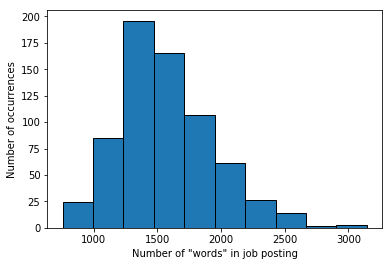

In [98]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(df.loc[:,'NUM_WORDS'], edgecolor='black')
ax.set_xlabel('Number of words in job posting')
_=ax.set_ylabel('Number of occurrences')